# 07차시: 금융 시계열 데이터 시각화 (주가 차트 그리기)

## 학습 목표
- Matplotlib을 이용한 주가 시계열 차트 시각화 기법 학습
- 종가 + 거래량 복합 차트 작성법 학습
- 캔들스틱 차트 그리기
- 차트 꾸미기 기법 (annotate, fill_between 등)

## 학습 내용
1. 가상 주가 데이터 생성
2. 기본 꺾은선 그래프 (종가 추이)
3. 종가 + 거래량 복합 차트
4. 캔들스틱 차트
5. 차트 꾸미기 기법


In [1]:
# 라이브러리 설치
!pip install mplfinance -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.2 MB/s eta 0:00:00


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package fonts-nanum.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Korean font ready: NanumGothic
   - path: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


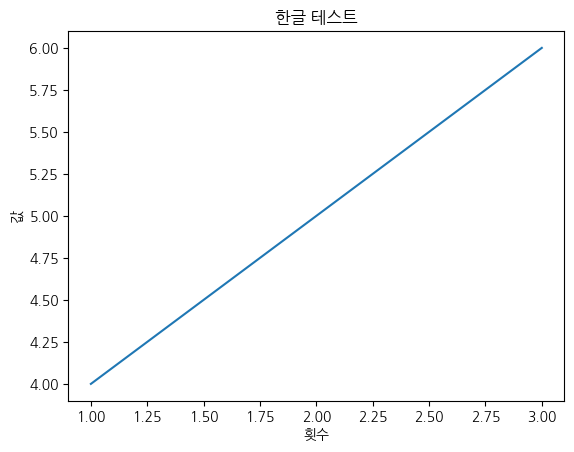

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

def setup_korean_font_colab(force=False, verbose=True):
    """
    Colab + Matplotlib에서 한글이 절대 깨지지 않도록 하는 통합 함수

    - 폰트 설치 (최초 1회)
    - fontManager에 즉시 등록 (런타임 재시작 불필요)
    - rcParams 재확정 (새 Figure, 로그 스케일, legend 대응)
    - PDF 저장 시 폰트 임베딩까지 처리

    force=True  -> rcParams를 무조건 다시 설정
    """

    import os
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"

    # 1) 폰트 설치 (없을 때만)
    if not os.path.exists(font_path):
        !apt-get update -qq
        !apt-get install -y fonts-nanum -qq
        pass

    # 2) Matplotlib에 폰트 등록 (중요: 재시작 불필요)
    try:
        fm.fontManager.addfont(font_path)
    except Exception:
        pass  # 이미 등록돼 있으면 무시

    # 3) 폰트 이름 확정
    font_name = fm.FontProperties(fname=font_path).get_name()

    # 4) rcParams 재확정
    mpl.rcParams["font.family"] = font_name
    mpl.rcParams["axes.unicode_minus"] = False
    mpl.rcParams["pdf.fonttype"] = 42
    mpl.rcParams["ps.fonttype"] = 42

    if verbose:
        print(f"Korean font ready: {font_name}")
        print(f"   - path: {font_path}")

    return font_name

setup_korean_font_colab()

# 테스트
plt.plot([1, 2, 3], [4, 5, 6])
plt.title('한글 테스트')
plt.xlabel('횟수')
plt.ylabel('값')
plt.show()

---
## 1. 가상 주가 데이터 생성

시각화 학습에 집중하기 위해 가상의 주가 데이터를 생성합니다.
실제 주가 데이터 수집은 다음 차시(08차시)에서 학습합니다.

In [3]:
# 가상 주가 데이터 생성
print("[가상 주가 데이터 생성]")
print("=" * 60)

# 재현성을 위한 시드 설정
np.random.seed(42)

# 120일 영업일 기준 날짜 생성 (약 6개월)
dates = pd.date_range('2024-01-01', periods=120, freq='B')

# 기준 가격 (삼성전자 수준의 가격대)
base_price = 70000

# 가격 변동 시뮬레이션 (랜덤워크 + 약간의 상승 추세)
np.random.seed(42)
daily_returns = np.random.randn(120) * 0.015 + 0.0003  # 일일 변동 + 미세 상승
price_multipliers = np.cumprod(1 + daily_returns)
prices = base_price * price_multipliers

# OHLCV 데이터 생성
df = pd.DataFrame({
    '시가': (prices * (1 + np.random.randn(120) * 0.003)).astype(int),
    '고가': (prices * (1 + abs(np.random.randn(120) * 0.008))).astype(int),
    '저가': (prices * (1 - abs(np.random.randn(120) * 0.008))).astype(int),
    '종가': prices.astype(int),
    '거래량': np.random.randint(10_000_000, 30_000_000, 120)
}, index=dates)
df.index.name = '날짜'

# 고가가 종가보다 크고, 저가가 종가보다 작도록 보정
df['고가'] = df[['고가', '종가', '시가']].max(axis=1)
df['저가'] = df[['저가', '종가', '시가']].min(axis=1)

print(f"종목: 가상 주식 (삼성전자 가격대)")
print(f"데이터 크기: {df.shape[0]}행 x {df.shape[1]}열")
print(f"기간: {df.index[0].strftime('%Y-%m-%d')} ~ {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\n처음 5개 데이터:")
df.head()

[가상 주가 데이터 생성]
종목: 가상 주식 (삼성전자 가격대)
데이터 크기: 120행 x 5열
기간: 2024-01-01 ~ 2024-06-14

처음 5개 데이터:


,시가,고가,저가,종가,거래량
날짜,,,,,
2024-01-01,70709,70989,70249,70542,10118033
2024-01-02,70225,70482,69553,70417,19018873
2024-01-03,71421,71421,71060,71122,21098917
2024-01-04,72462,73272,72462,72768,15872354
2024-01-05,72662,73231,72134,72535,11215502


In [7]:
# 데이터 기본 정보 확인
print("[데이터 기본 정보]")
print("=" * 60)
print(f"컬럼: {df.columns.tolist()}")
print(f"\n기술 통계량:")
df.describe().round(0)

[데이터 기본 정보]
컬럼: ['시가', '고가', '저가', '종가', '거래량']

기술 통계량:


,시가,고가,저가,종가,거래량
count,120.0,120.0,120.0,120.0,120.0
mean,63699.0,64081.0,63237.0,63686.0,20400805.0
std,4261.0,4377.0,4276.0,4272.0,5818249.0
min,58249.0,58628.0,58012.0,58408.0,10064323.0
25%,60955.0,61318.0,60408.0,60965.0,15856691.0
50%,62150.0,62604.0,61694.0,62168.0,19902065.0
75%,65192.0,66084.0,64668.0,65266.0,25635811.0
max,74920.0,75589.0,74783.0,75033.0,29931456.0


---
## 2. 기본 꺾은선 그래프 (종가 추이)

가장 기본적인 시계열 시각화인 꺾은선 그래프(Line Chart)를 그려봅니다.

[기본 종가 차트]


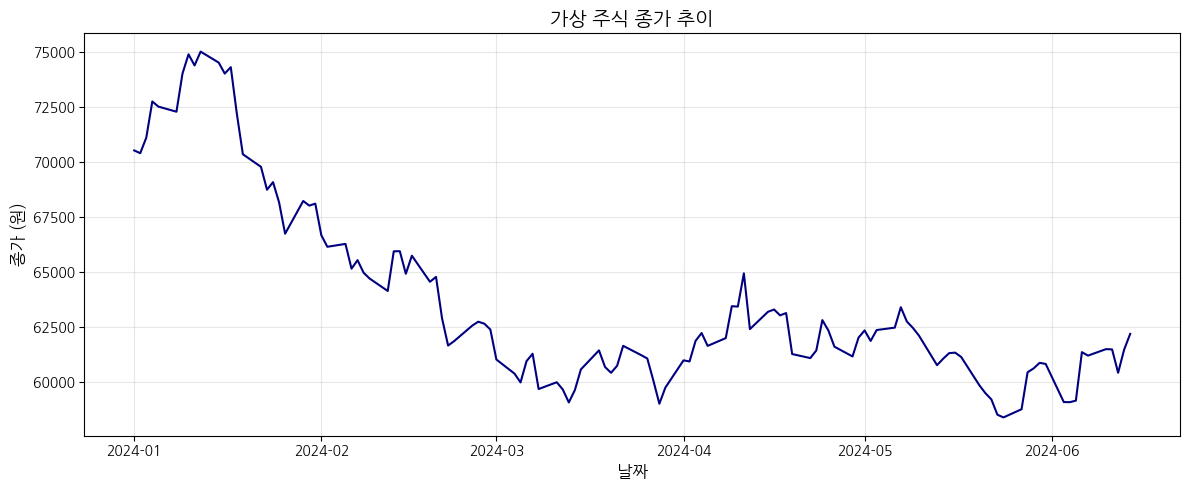

In [9]:
# 실습 2-1: 기본 종가 차트
print("[기본 종가 차트]")
print("=" * 60)

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['종가'], color='navy', linewidth=1.5)
plt.title('가상 주식 종가 추이', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('종가 (원)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[스타일이 개선된 종가 차트]


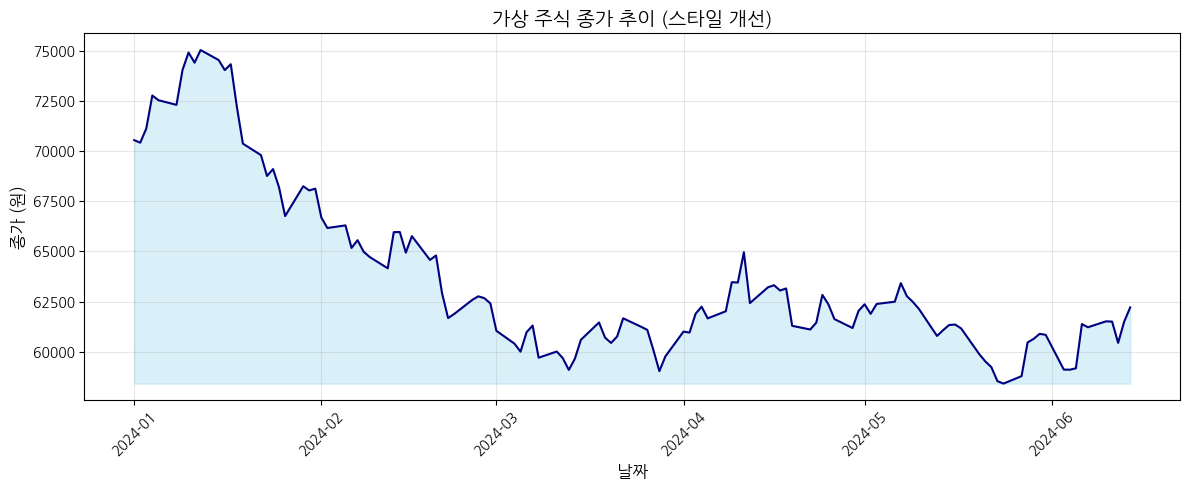

In [10]:
# 실습 2-2: 차트 스타일 개선
print("[스타일이 개선된 종가 차트]")
print("=" * 60)

plt.figure(figsize=(12, 5))

# 영역 채우기 (fill_between)
plt.fill_between(df.index, df['종가'], df['종가'].min(), alpha=0.3, color='skyblue')
plt.plot(df.index, df['종가'], color='navy', linewidth=1.5)

# x축 날짜 포맷 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.title('가상 주식 종가 추이 (스타일 개선)', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('종가 (원)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 3. 종가 + 거래량 복합 차트

주가 분석에서 가장 많이 사용되는 형태로, 상단에 종가, 하단에 거래량을 표시합니다.
`plt.subplots()`를 사용하여 여러 차트를 하나의 Figure에 배치합니다.

[종가 + 거래량 복합 차트]


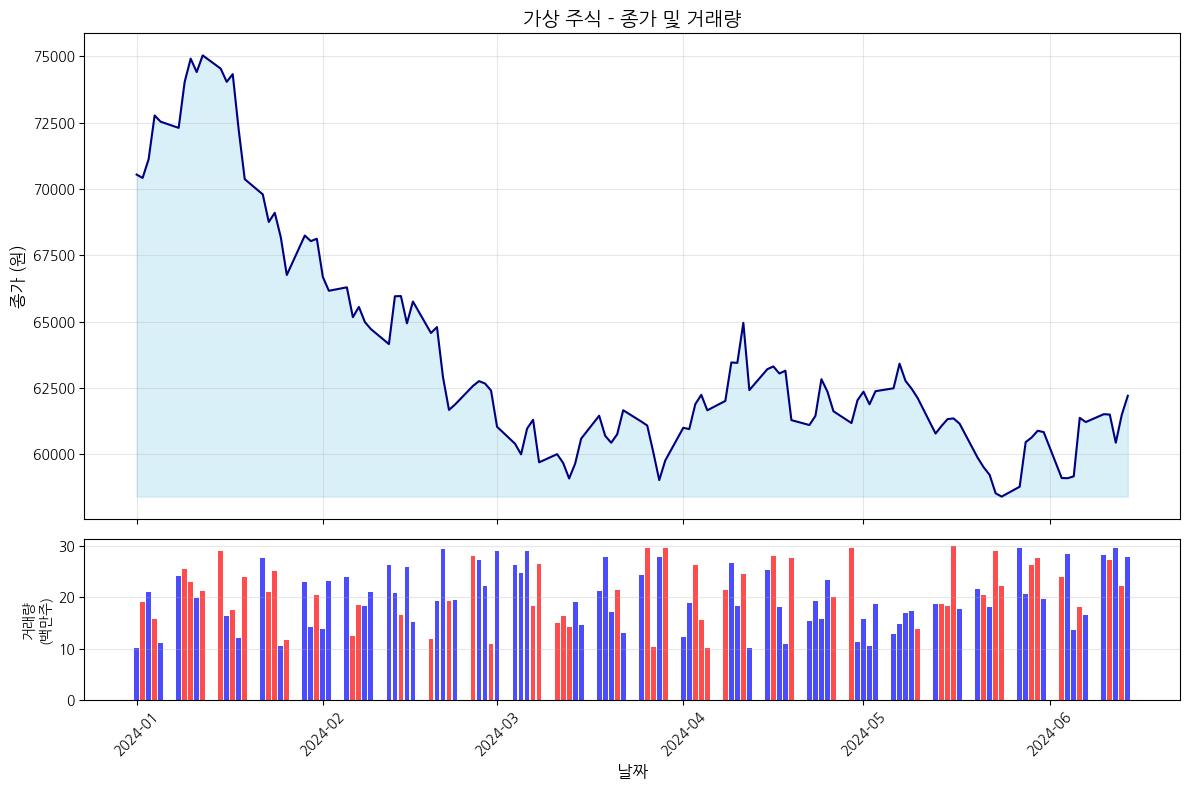

[설명] subplots()로 2개의 차트를 상하로 배치했습니다.
       sharex=True로 x축을 공유합니다.
       거래량 색상: 빨강=상승일, 파랑=하락일


In [11]:
# 실습 3-1: 종가 + 거래량 복합 차트
print("[종가 + 거래량 복합 차트]")
print("=" * 60)

# 2행 1열 subplot 생성 (높이 비율 3:1)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8),
                               gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# 상단: 종가 차트
ax1.fill_between(df.index, df['종가'], df['종가'].min(), alpha=0.3, color='skyblue')
ax1.plot(df.index, df['종가'], color='navy', linewidth=1.5)
ax1.set_title('가상 주식 - 종가 및 거래량', fontsize=14, fontweight='bold')
ax1.set_ylabel('종가 (원)', fontsize=12)
ax1.grid(True, alpha=0.3)

# 하단: 거래량 차트 (상승=빨강, 하락=파랑)
colors = ['red' if df.iloc[i]['종가'] >= df.iloc[i]['시가'] else 'blue'
          for i in range(len(df))]
ax2.bar(df.index, df['거래량'] / 1_000_000, color=colors, alpha=0.7, width=0.8)
ax2.set_ylabel('거래량\n(백만주)', fontsize=10)
ax2.set_xlabel('날짜', fontsize=12)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("[설명] subplots()로 2개의 차트를 상하로 배치했습니다.")
print("       sharex=True로 x축을 공유합니다.")
print("       거래량 색상: 빨강=상승일, 파랑=하락일")

---
## 4. 캔들스틱 차트 (Candlestick Chart)

캔들스틱 차트는 OHLC(시가, 고가, 저가, 종가) 데이터를 한 눈에 보여주는 차트입니다.
`mplfinance` 라이브러리를 사용하면 쉽게 그릴 수 있습니다.

[캔들스틱 차트]


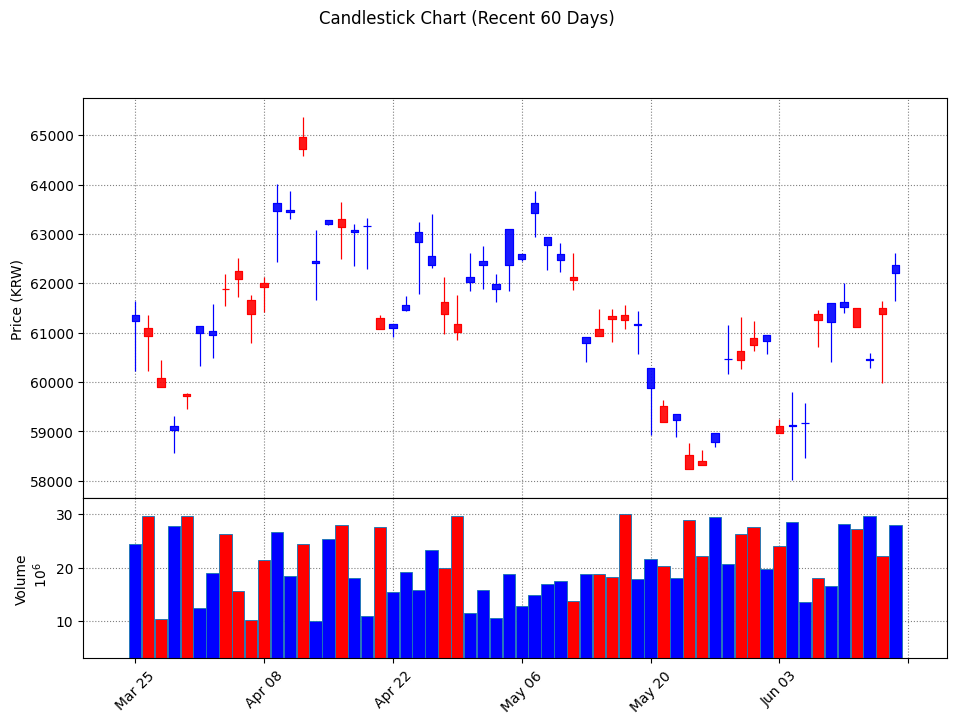

[설명] mplfinance로 캔들스틱 차트를 그렸습니다.
       빨간색 양봉: 상승 (종가 > 시가)
       파란색 음봉: 하락 (종가 < 시가)


In [12]:
# 실습 4: mplfinance로 캔들스틱 차트 그리기
print("[캔들스틱 차트]")
print("=" * 60)

import mplfinance as mpf

# mplfinance용 데이터 준비 (영문 컬럼명 필수)
df_mpf = df[['시가', '고가', '저가', '종가', '거래량']].copy()
df_mpf.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# 최근 60일 데이터만 사용 (너무 많으면 보기 어려움)
df_recent = df_mpf.tail(60)

# 한국식 색상 (상승=빨강, 하락=파랑)
mc = mpf.make_marketcolors(up='red', down='blue', edge='inherit', wick='inherit', volume='in')
s = mpf.make_mpf_style(marketcolors=mc, gridstyle=':', gridcolor='gray')

# 캔들스틱 차트 그리기
mpf.plot(df_recent, type='candle', style=s,
         title='Candlestick Chart (Recent 60 Days)',
         ylabel='Price (KRW)',
         ylabel_lower='Volume',
         volume=True,
         figsize=(12, 8))

print("[설명] mplfinance로 캔들스틱 차트를 그렸습니다.")
print("       빨간색 양봉: 상승 (종가 > 시가)")
print("       파란색 음봉: 하락 (종가 < 시가)")

---
## 5. 차트 꾸미기 기법

차트에 추가 정보를 표시하는 다양한 기법을 학습합니다.
- annotate(): 특정 지점에 주석 추가
- scatter(): 특정 포인트 강조
- axhline(), axvline(): 수평/수직선 추가
- fill_between(): 영역 채우기

In [16]:
_ = setup_korean_font_colab()

Korean font ready: NanumGothic
   - path: /usr/share/fonts/truetype/nanum/NanumGothic.ttf


[최고/최저 지점 표시]


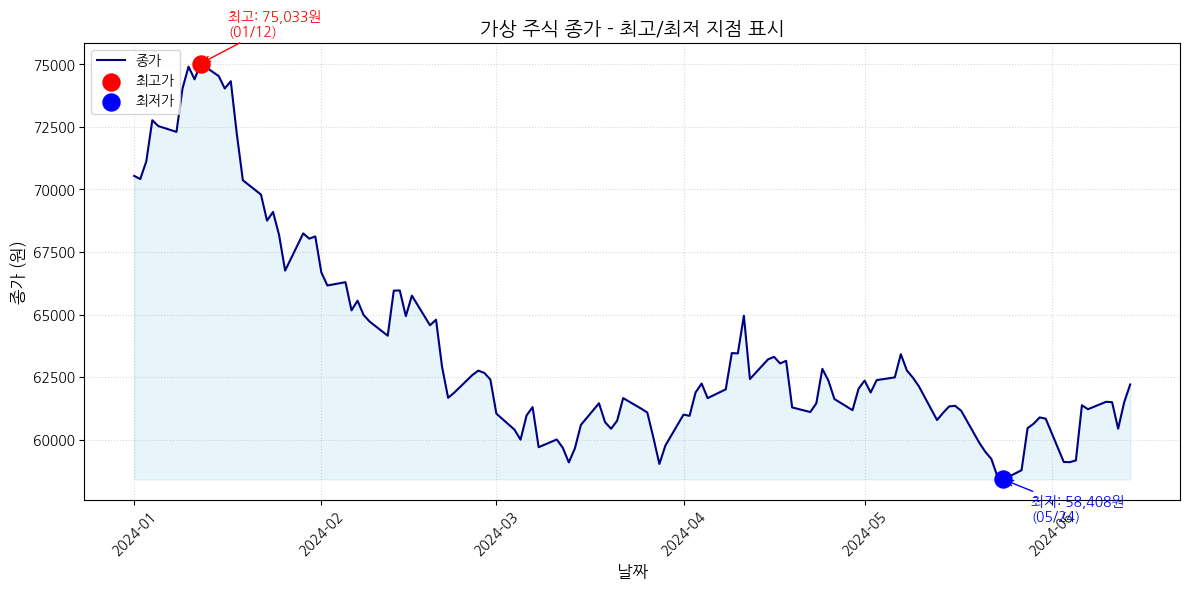

[정보] 최고가: 75,033원 (2024-01-12)
[정보] 최저가: 58,408원 (2024-05-24)


In [17]:
# 실습 5-1: 최고/최저 지점 표시
print("[최고/최저 지점 표시]")
print("=" * 60)

plt.figure(figsize=(12, 6))

# 기본 차트
plt.fill_between(df.index, df['종가'], df['종가'].min(), alpha=0.2, color='skyblue')
plt.plot(df.index, df['종가'], color='navy', linewidth=1.5, label='종가')

# 최고/최저 지점 찾기
max_idx = df['종가'].idxmax()
min_idx = df['종가'].idxmin()
max_val = df['종가'].max()
min_val = df['종가'].min()

# 최고/최저 지점에 점 표시
plt.scatter([max_idx], [max_val], color='red', s=150, zorder=5, label='최고가')
plt.scatter([min_idx], [min_val], color='blue', s=150, zorder=5, label='최저가')

# annotate로 텍스트 추가
plt.annotate(f'최고: {max_val:,}원\n({max_idx.strftime("%m/%d")})',
             xy=(max_idx, max_val),
             xytext=(20, 20), textcoords='offset points',
             fontsize=10, color='red',
             arrowprops=dict(arrowstyle='->', color='red'))

plt.annotate(f'최저: {min_val:,}원\n({min_idx.strftime("%m/%d")})',
             xy=(min_idx, min_val),
             xytext=(20, -30), textcoords='offset points',
             fontsize=10, color='blue',
             arrowprops=dict(arrowstyle='->', color='blue'))

plt.title('가상 주식 종가 - 최고/최저 지점 표시', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('종가 (원)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"[정보] 최고가: {max_val:,}원 ({max_idx.strftime('%Y-%m-%d')})")
print(f"[정보] 최저가: {min_val:,}원 ({min_idx.strftime('%Y-%m-%d')})")

[수평선으로 기준가 표시]


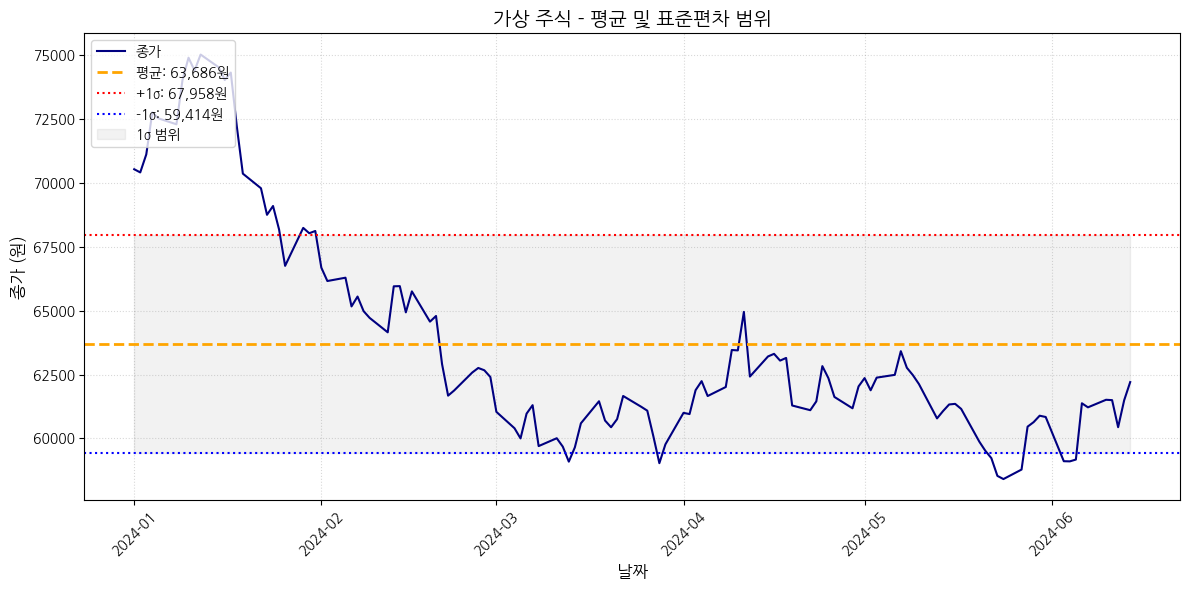

[설명] axhline()으로 수평선을 추가하여 기준가를 표시했습니다.
       평균가: 63,686원
       표준편차: 4,272원


In [19]:
# 실습 5-2: 수평선으로 기준가 표시
print("[수평선으로 기준가 표시]")
print("=" * 60)

# 평균가와 표준편차 계산
mean_price = df['종가'].mean()
std_price = df['종가'].std()

plt.figure(figsize=(12, 6))

# 종가 차트
plt.plot(df.index, df['종가'], color='navy', linewidth=1.5, label='종가')

# 수평선 추가
plt.axhline(y=mean_price, color='orange', linestyle='--', linewidth=2, label=f'평균: {mean_price:,.0f}원')
plt.axhline(y=mean_price + std_price, color='red', linestyle=':', linewidth=1.5, label=f'+1σ: {mean_price + std_price:,.0f}원')
plt.axhline(y=mean_price - std_price, color='blue', linestyle=':', linewidth=1.5, label=f'-1σ: {mean_price - std_price:,.0f}원')

# 표준편차 범위 채우기
plt.fill_between(df.index, mean_price - std_price, mean_price + std_price,
                 alpha=0.1, color='gray', label='1σ 범위')

plt.title('가상 주식 - 평균 및 표준편차 범위', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('종가 (원)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("[설명] axhline()으로 수평선을 추가하여 기준가를 표시했습니다.")
print(f"       평균가: {mean_price:,.0f}원")
print(f"       표준편차: {std_price:,.0f}원")

[특정 기간 강조]


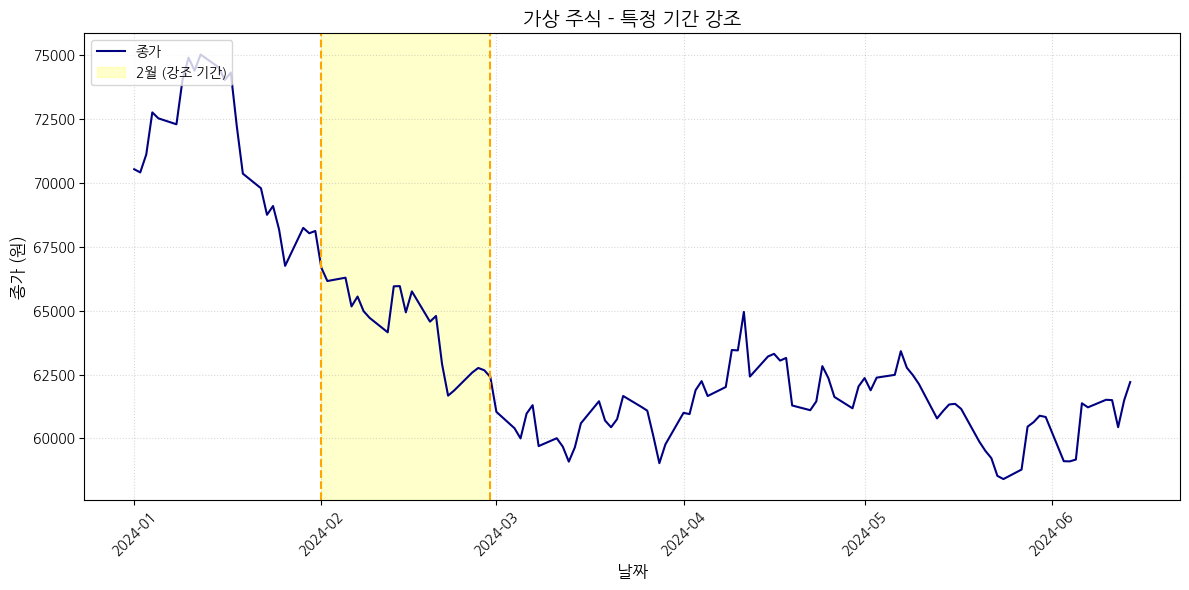

[설명] axvspan()으로 특정 기간을 강조 표시했습니다.
       axvline()으로 수직선을 추가할 수 있습니다.


In [20]:
# 실습 5-3: 특정 기간 강조
print("[특정 기간 강조]")
print("=" * 60)

plt.figure(figsize=(12, 6))

# 종가 차트
plt.plot(df.index, df['종가'], color='navy', linewidth=1.5, label='종가')

# 특정 기간 강조 (2월)
highlight_start = pd.Timestamp('2024-02-01')
highlight_end = pd.Timestamp('2024-02-29')

# axvspan으로 영역 표시
plt.axvspan(highlight_start, highlight_end, alpha=0.2, color='yellow', label='2월 (강조 기간)')

# axvline으로 시작/끝 표시
plt.axvline(x=highlight_start, color='orange', linestyle='--', linewidth=1.5)
plt.axvline(x=highlight_end, color='orange', linestyle='--', linewidth=1.5)

plt.title('가상 주식 - 특정 기간 강조', fontsize=14, fontweight='bold')
plt.xlabel('날짜', fontsize=12)
plt.ylabel('종가 (원)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("[설명] axvspan()으로 특정 기간을 강조 표시했습니다.")
print("       axvline()으로 수직선을 추가할 수 있습니다.")

---
## 학습 정리

### 1. 기본 꺾은선 그래프
- `plt.plot()`: 기본 라인 차트
- `plt.fill_between()`: 영역 채우기
- `mdates`: 날짜 포맷 설정

### 2. 복합 차트
- `plt.subplots()`: 여러 차트 배치
- `sharex=True`: x축 공유
- `gridspec_kw`: 높이 비율 설정

### 3. 캔들스틱 차트
- `mplfinance`: 금융 차트 전문 라이브러리
- `type='candle'`: 캔들스틱 차트
- `make_marketcolors()`: 색상 커스터마이징

### 4. 차트 꾸미기
- `annotate()`: 주석 추가
- `scatter()`: 점 표시
- `axhline()`, `axvline()`: 수평/수직선
- `axvspan()`: 영역 강조

---

### 다음 차시 예고
- 08차시: [실습] 국내 주식 데이터 수집 및 기본 분석
  - pykrx로 실제 KOSPI 데이터 수집
  - Pandas 통계 분석
  - 여러 종목 비교 (로그 스케일, 정규화)